# Extreme-based method

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import seaborn as sns
from xclim.indices import standardized_precipitation_evapotranspiration_index
import spei as si  # si for standardized index
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import colormaps as cmaps


### 0.1 degrees

/tmp/ipykernel_59873/411647563.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_continuous = plt.cm.get_cmap(cmap)


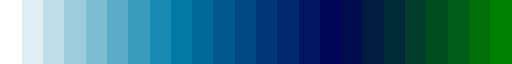

In [3]:
# Function to create a discrete colormap from a continuous colormap
def create_discrete_colormap(cmap, num_colors):
    cmap_continuous = plt.cm.get_cmap(cmap)
    colors_continuous = cmap_continuous(np.linspace(0, 1, num_colors))
    cmap_discrete = plt.matplotlib.colors.ListedColormap(colors_continuous)
    return cmap_discrete

# Example usage:
cmap_discrete = create_discrete_colormap("ocean_r", 24)
cmap_discrete

/tmp/ipykernel_59873/1230909115.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_continuous = plt.cm.get_cmap(cmap)


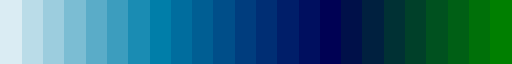

In [4]:
def create_discrete_colormap(cmap, num_colors):
    cmap_continuous = plt.cm.get_cmap(cmap)
    colors_continuous = cmap_continuous(np.linspace(0.05, 1, num_colors))  # Adjusted range, excluding white
    cmap_discrete = plt.matplotlib.colors.ListedColormap(colors_continuous)
    return cmap_discrete

# Example usage:
cmap_discrete_light = create_discrete_colormap("ocean_r", 24)
cmap_discrete_light

Definition of the extreme-based method

In [5]:
def extreme(EVI_an, SPEI, dir):
    # Create a new dimension for SPEI
    spei_dimension = xr.DataArray([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
                                dims='SPEI', name='SPEI')

    # Expand the dimension along 'SPEI' and copy the existing data along this dimension
    EVI_grid_AUS_an_ = EVI_an.expand_dims(SPEI=spei_dimension).transpose('SPEI', 'time', 'lat', 'lon')

    t = -1
    SPEI_grid_threshold = SPEI.where(SPEI < t)
    EVI_grid_AUS_an_threshold = EVI_grid_AUS_an_.where(SPEI < t)

    EVI_grid_AUS_an_threshold_mean = EVI_grid_AUS_an_threshold.mean("time")

    EVI_grid_AUS_an_threshold_mean_min = EVI_grid_AUS_an_threshold_mean.min("SPEI")
    print("combine")
    combined = []
    for spei,i in zip(EVI_grid_AUS_an_threshold_mean['SPEI'],range(1,len(EVI_grid_AUS_an_threshold_mean['SPEI'])+1)):
        months = ((EVI_grid_AUS_an_threshold_mean.sel(SPEI = i).where(EVI_grid_AUS_an_threshold_mean.sel(SPEI = i) == EVI_grid_AUS_an_threshold_mean_min))/(EVI_grid_AUS_an_threshold_mean.sel(SPEI = i).where(EVI_grid_AUS_an_threshold_mean.sel(SPEI = i) == EVI_grid_AUS_an_threshold_mean_min)))*spei
        combined.append(months)

    print("concat")
    SPEI_timescale = xr.concat(combined, dim='SPEI')
    collapsed_SPEI_timescale = SPEI_timescale.mean(dim='SPEI')
    print("saving")
    collapsed_SPEI_timescale.to_netcdf(dir)
    return collapsed_SPEI_timescale


Load the data

In [ ]:
file_paths = [f"/scratch/ruiij001/Data/SPEI/0_1_degrees_apr_2024/Compessed/SPEI{i:02d}_monthly_2000_2023_0_1_degree.nc" for i in range(1, 25)]

# Load the data into a single xarray data array
SPEI_grid = xr.open_mfdataset(file_paths, combine='nested', concat_dim="SPEI").__xarray_dataarray_variable__.sel(time=slice("2000-02", "2022"))
SPEI_grid

In [ ]:
EVI_an = xr.open_dataset("/scratch/ruiij001/Data/EVI/EVI_st_an_2000_2022_0_1_degree.nc").EVI
EVI_an

<xarray.DataArray 'EVI' (time: 275, lon: 3600, lat: 1800)>
[1782000000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2000-02-01 2000-03-01 ... 2022-12-01
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 -90.0 -89.9 -89.8 -89.7 -89.6 ... 89.6 89.7 89.8 89.9
    month    (time) int64 ...

The world is too big to do it in one part, so divide the world in 16 parts and later combine these.

In [ ]:
SPEI_part1 = SPEI_grid.sel(lat = slice(-90,-45), lon = slice(-180,-90))
SPEI_part2 = SPEI_grid.sel(lat = slice(-90,-45), lon = slice(-90,0))
SPEI_part3 = SPEI_grid.sel(lat = slice(-45,0), lon = slice(-180,-90))
SPEI_part4 = SPEI_grid.sel(lat = slice(-45,0), lon = slice(-90,0))
SPEI_part5 = SPEI_grid.sel(lat = slice(0,45), lon = slice(-180,-90))
SPEI_part6 = SPEI_grid.sel(lat = slice(0,45), lon = slice(-90,0))
SPEI_part7 = SPEI_grid.sel(lat = slice(45,90), lon = slice(-180,-90))
SPEI_part8 = SPEI_grid.sel(lat = slice(45,90), lon = slice(-90,0))

SPEI_part9 = SPEI_grid.sel(lat = slice(-90,-45), lon = slice(0,90))
SPEI_part10 = SPEI_grid.sel(lat = slice(-90,-45), lon = slice(90,180))
SPEI_part11 = SPEI_grid.sel(lat = slice(-45,0), lon = slice(0,90))
SPEI_part12 = SPEI_grid.sel(lat = slice(-45,0), lon = slice(90,180))
SPEI_part13 = SPEI_grid.sel(lat = slice(0,45), lon = slice(0,90))
SPEI_part14 = SPEI_grid.sel(lat = slice(0,45), lon = slice(90,180))
SPEI_part15 = SPEI_grid.sel(lat = slice(45,90), lon = slice(0,90))
SPEI_part16 = SPEI_grid.sel(lat = slice(45,90), lon = slice(90,180))

In [ ]:
EVI_an_part1 = EVI_an.sel(lat = slice(-90,-45), lon = slice(-180,-90))
EVI_an_part2 = EVI_an.sel(lat = slice(-90,-45), lon = slice(-90,0))
EVI_an_part3 = EVI_an.sel(lat = slice(-45,0), lon = slice(-180,-90))
EVI_an_part4 = EVI_an.sel(lat = slice(-45,0), lon = slice(-90,0))
EVI_an_part5 = EVI_an.sel(lat = slice(0,45), lon = slice(-180,-90))
EVI_an_part6 = EVI_an.sel(lat = slice(0,45), lon = slice(-90,0))
EVI_an_part7 = EVI_an.sel(lat = slice(45,90), lon = slice(-180,-90))
EVI_an_part8 = EVI_an.sel(lat = slice(45,90), lon = slice(-90,0))

EVI_an_part9 = EVI_an.sel(lat = slice(-90,-45), lon = slice(0,90))
EVI_an_part10 = EVI_an.sel(lat = slice(-90,-45), lon = slice(90,180))
EVI_an_part11 = EVI_an.sel(lat = slice(-45,0), lon = slice(0,90))
EVI_an_part12 = EVI_an.sel(lat = slice(-45,0), lon = slice(90,180))
EVI_an_part13 = EVI_an.sel(lat = slice(0,45), lon = slice(0,90))
EVI_an_part14 = EVI_an.sel(lat = slice(0,45), lon = slice(90,180))
EVI_an_part15 = EVI_an.sel(lat = slice(45,90), lon = slice(0,90))
EVI_an_part16 = EVI_an.sel(lat = slice(45,90), lon = slice(90,180))

In [ ]:
resolution = "0_1_degrees"

SPEI_timescale_global_part1 = extreme(EVI_an_part1, SPEI_part1, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part1_"+resolution+".nc")
SPEI_timescale_global_part2 = extreme(EVI_an_part2, SPEI_part2, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part2_"+resolution+".nc")
SPEI_timescale_global_part3 = extreme(EVI_an_part3, SPEI_part3, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part3_"+resolution+".nc")
SPEI_timescale_global_part4 = extreme(EVI_an_part4, SPEI_part4, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part4_"+resolution+".nc")
SPEI_timescale_global_part5 = extreme(EVI_an_part5, SPEI_part5, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part5_"+resolution+".nc")
SPEI_timescale_global_part6 = extreme(EVI_an_part6, SPEI_part6, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part6_"+resolution+".nc")
SPEI_timescale_global_part7 = extreme(EVI_an_part7, SPEI_part7, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part7_"+resolution+".nc")
SPEI_timescale_global_part8 = extreme(EVI_an_part8, SPEI_part8, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part8_"+resolution+".nc")
SPEI_timescale_global_part9 = extreme(EVI_an_part9, SPEI_part9, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part9_"+resolution+".nc")
SPEI_timescale_global_part10 = extreme(EVI_an_part10, SPEI_part10, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part10_"+resolution+".nc")
SPEI_timescale_global_part11 = extreme(EVI_an_part11, SPEI_part11, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part11_"+resolution+".nc")
SPEI_timescale_global_part12 = extreme(EVI_an_part12, SPEI_part12, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part12_"+resolution+".nc")
SPEI_timescale_global_part13 = extreme(EVI_an_part13, SPEI_part13, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part13_"+resolution+".nc")
SPEI_timescale_global_part14 = extreme(EVI_an_part14, SPEI_part14, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part14_"+resolution+".nc")
SPEI_timescale_global_part15 = extreme(EVI_an_part15, SPEI_part15, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part15_"+resolution+".nc")
SPEI_timescale_global_part16 = extreme(EVI_an_part16, SPEI_part16, dir = "/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part16_"+resolution+".nc")


Open all 16 files and merge them

In [ ]:
SPEI_timescales = xr.open_mfdataset("/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2022_0_1_degree_part*_0_1_degrees.nc").__xarray_dataarray_variable__
SPEI_timescales_ = SPEI_timescales.drop_duplicates(dim='lon').drop_duplicates(dim='lat')
SPEI_timescales_

Save this file as a new netcdf file

In [ ]:
SPEI_timescales_.to_netcdf("/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2023_0_1_degree_"+resolution+".nc")

### 0.5

0.5 degrees not possible because EVI data is at 0.1 degrees